### Seleção de Portfolio:
Para construir os portifolios, deve se levar em consideração os critérios de seleção de ativos, e ranqueamento de ordem das ações.

### Bibliotecas

In [23]:
!pip install pyreadr
!pip install graphviz

In [1]:
# Basic stuff
import pandas as pd
import numpy as np
import datetime
from calendar import monthrange
from dateutil.relativedelta import relativedelta

# Plotting
import matplotlib.pyplot as plt
import seaborn as sns
plt.style.use('seaborn')
plt.rcParams['patch.facecolor'] = 'white' # This is helpful if you're using Colab in dark mode
plt.rcParams['figure.figsize'] = 15, 7
# import graphviz

# Reading Rdata - need to install in Collab
# import pyreadr

# Regression type stuff
from statsmodels.formula.api import ols
from statsmodels.graphics.tsaplots import plot_pacf
from statsmodels.distributions.empirical_distribution import ECDF
from sklearn.linear_model import Lasso, Ridge, ElasticNet

# Trees
from sklearn import tree
from sklearn.ensemble import RandomForestRegressor, RandomForestClassifier, AdaBoostClassifier, GradientBoostingClassifier

# Deep learning stuff
import tensorflow as tf
from tensorflow import keras

/var/folders/2p/yszv_4ds72bb4gcspfnbc3vw0000gn/T/ipykernel_1056/2708523443.py:11: MatplotlibDeprecationWarning: The seaborn styles shipped by Matplotlib are deprecated since 3.6, as they no longer correspond to the styles shipped by seaborn. However, they will remain available as 'seaborn-v0_8-<style>'. Alternatively, directly use the seaborn API instead.
  plt.style.use('seaborn')
2023-06-21 09:54:30.243461: I tensorflow/core/platform/cpu_feature_guard.cc:182] This TensorFlow binary is optimized to use available CPU instructions in performance-critical operations.
To enable the following instructions: AVX2 FMA, in other operations, rebuild TensorFlow with the appropriate compiler flags.


In [2]:
#lendo os fatores:
ff_factors = pd.read_csv("../data/risk_factors/factors.csv",index_col=None)
# ajustando os tipos das colunas:
ff_factors['date'] = pd.to_datetime(ff_factors['date'])
# ff_factors['date'] = ff_factors['date'].dt.strftime("%Y/%m/%d")
columns_to_float = ff_factors.columns[1:]
ff_factors[columns_to_float] = ff_factors[columns_to_float].astype(float)
display(ff_factors.head())


,date,Rm_minus_Rf,HML,IML,SMB,WML,Risk_free
0,2001-01-02,0.006601,0.065490,0.014109,0.000524,-0.006308,0.000579
1,2001-01-03,0.062427,0.009390,0.004510,0.005390,-0.028644,0.000577
2,2001-01-04,-0.000310,-0.002327,-0.009227,0.006690,-0.000946,0.000574
3,2001-01-05,-0.012839,-0.002397,0.025124,0.003523,0.005985,0.000573
4,2001-01-08,0.003982,0.001948,-0.001175,0.007883,-0.004099,0.000573


Text(0.5, 1.0, 'Average returns over time of common factors')

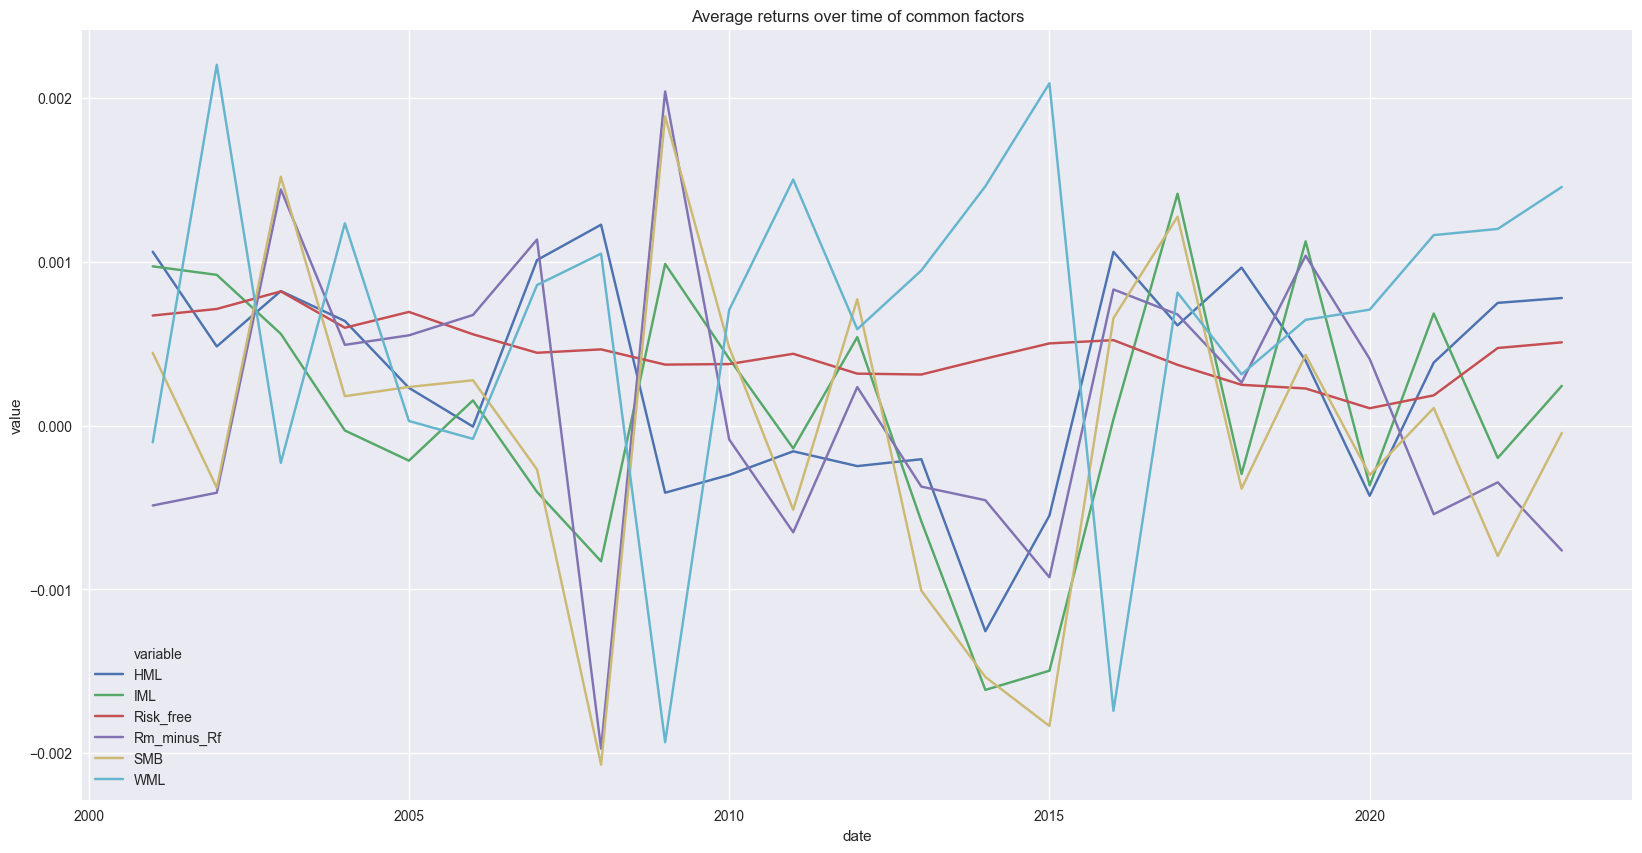

In [26]:
temp_factors = ff_factors.copy()

temp_factors['date'] = temp_factors['date'].dt.year
temp_factors = pd.melt(temp_factors, id_vars = 'date')
temp_factors = temp_factors.groupby(['date','variable']).mean().reset_index()
# increase the size of the plot:
lineplot = sns.lineplot(x='date',y='value',hue='variable', data = temp_factors)
lineplot.figure.set_size_inches(20, 10)
# lineplot.legend(bbox_to_anchor=(1.05, 0.7), loc=2, borderaxespad=0.)
lineplot.set_title('Average returns over time of common factors')

In [27]:
# vamos ver como os fatores se comportam em um portfolio:
# A função nos permite escolher uma data de início para o portfolio

def plot_cumulative_performance(df, start_date = None):

  # this function will plot cumulative performance for any wide dataframe of returns (e.g. index is date, columns are assets/factor)
  # optional: you can pass the start date in %m/%d/%y format e.g. '1/1/1995', '12/15/2000'
  # if you don't pass a start date, it will use the whole sample

  cumul_returns = (1+df.set_index('date')).cumprod()

  if start_date is None:
    start_date = cumul_returns.index.min()
  else:
    start_date = datetime.strptime(start_date, '%d/%m/%Y')
    cumul_returns = cumul_returns.loc[cumul_returns.index >= start_date]

  first_line = pd.DataFrame([[1. for col in cumul_returns.columns]],
                            columns = cumul_returns.columns,
                            index = [start_date - relativedelta(months=1)])

  cumul_returns = pd.concat([first_line,cumul_returns])

  return cumul_returns.plot(title = f'Cumulative factor performance since {start_date.strftime("%B %Y")}')


<Axes: title={'center': 'Cumulative factor performance since January 2001'}>

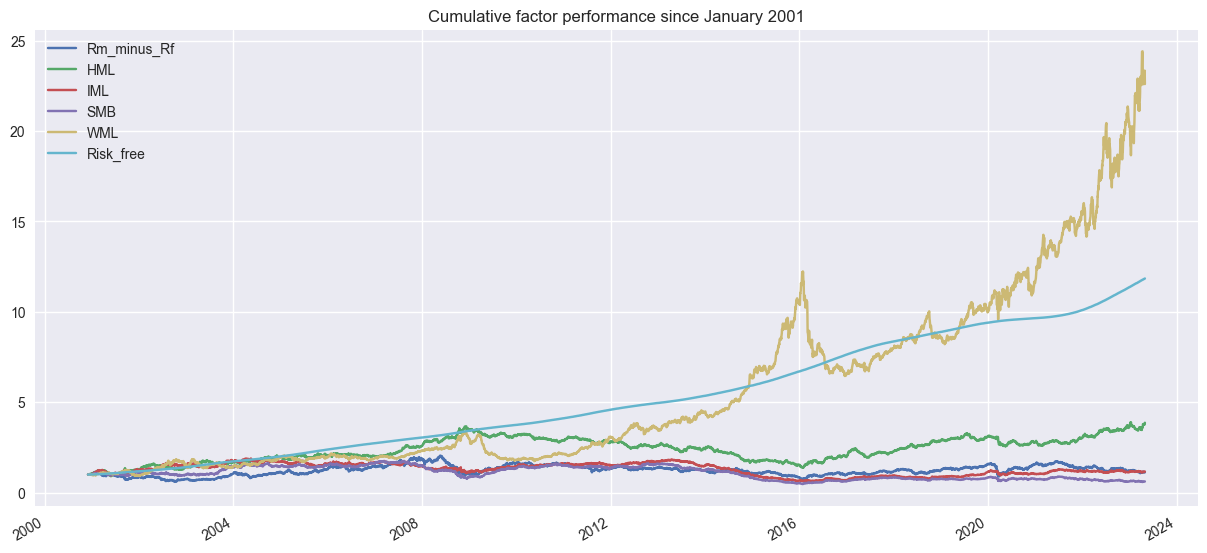

In [28]:
plot_cumulative_performance(ff_factors)

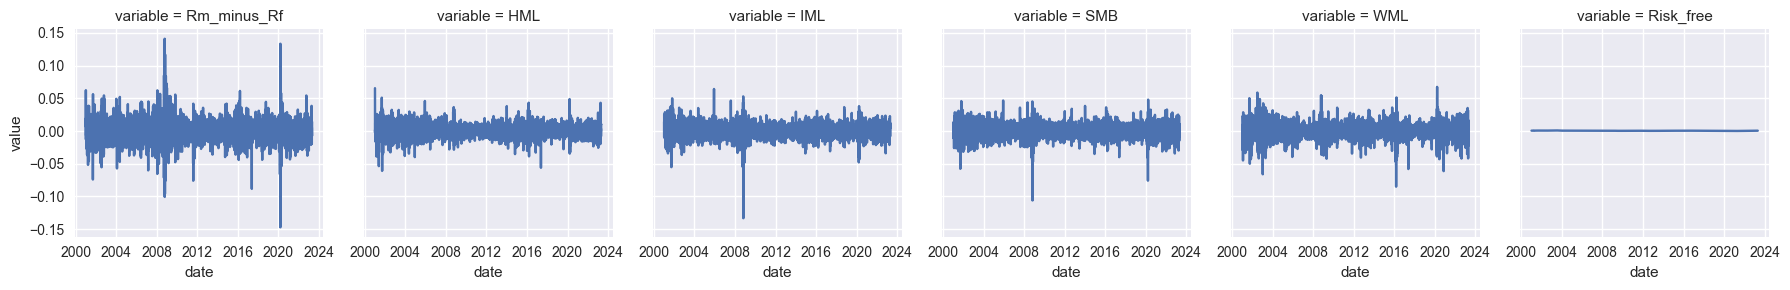

In [29]:
x = pd.melt(ff_factors, id_vars = 'date')
g = sns.FacetGrid(x, col='variable')
g.map(sns.lineplot, 'date', 'value')

In [30]:
from statsmodels.formula.api import ols
factor_comp = pd.melt(ff_factors.drop('Risk_free',axis=1),id_vars='date')

factor_comp = factor_comp.merge(ff_factors.drop('Risk_free',axis=1), on = 'date')

factor_comp_coefs = {}
factor_comp_tstats = {}

for k,g in factor_comp.groupby('variable'):

  reg_data = g.drop([k,'date','variable'],axis=1)
  formula = 'value ~ ' + ' + '.join(reg_data.columns.values[1:].tolist())
  
  model = ols(formula, data=reg_data)
  results = model.fit()

  factor_comp_coefs[k] = results.params
  factor_comp_tstats[k] = results.tvalues

alphas = pd.DataFrame.from_dict(factor_comp_coefs).T
alphas_tstats = pd.DataFrame.from_dict(factor_comp_tstats).T

alphas_tstats

,HML,IML,Intercept,Rm_minus_Rf,SMB,WML
HML,NaN,5.755685,2.453682,14.145168,6.182620,-2.503500
IML,5.755685,NaN,1.226122,-32.784479,86.952400,4.493869
Rm_minus_Rf,14.145168,-32.784479,1.237863,NaN,14.168563,-6.969435
SMB,6.182620,86.952400,-0.478255,14.168563,NaN,-19.110036
WML,-2.503500,4.493869,4.515045,-6.969435,-19.110036,NaN


In [31]:
alphas_table = alphas.round(3).applymap(str)

prob99 = 2.58
prob95 = 1.96

alphas_table[alphas_tstats >= prob99] = alphas_table[alphas_tstats >= prob99] + ' (**)'
alphas_table[alphas_tstats.apply(lambda x: x.between(prob95, prob99))] = alphas_table[alphas_tstats.apply(lambda x: x.between(prob95, prob99))] + ' (*)'

factors = factor_comp.columns[3:].tolist()

alphas_table = alphas_table[['Intercept'] + factors].reindex(factors)

alphas_table

,Intercept,Rm_minus_Rf,HML,IML,SMB,WML
Rm_minus_Rf,0.0,nan,0.306 (**),-0.99,0.447 (**),-0.127
HML,0.0 (*),0.114 (**),nan,0.116 (**),0.121 (**),-0.028
IML,0.0,-0.165,0.051 (**),nan,0.739 (**),0.033 (**)
SMB,-0.0,0.079 (**),0.057 (**),0.782 (**),nan,-0.142
WML,0.001 (**),-0.069,-0.04,0.109 (**),-0.437,nan


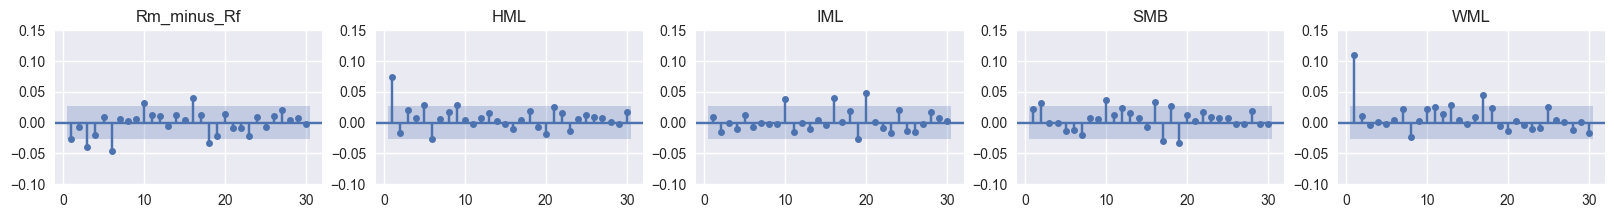

In [32]:

nfactors = len(factors)

#plot y from -0.1 to 0.1:

fig, axs = plt.subplots(ncols=nfactors, figsize = (20,2))



for i, factor in enumerate(factors):
  ax = axs[i]
  plot_pacf(ff_factors[factor], ax = axs[i], lags = 30, zero = False, title = factor)
  ax.set_ylim(-0.1, 0.15)

In [33]:
ibov = pd.read_csv("../data/IBOV.csv",index_col=None)
display(ibov.head())
# reality check:
# Número de tickers únicos no ibov:
display(f'Number of unique tickers in ibov: {ibov["ticker"].nunique()}')
# Número de datas únicas no ibov:
display(f'Number of unique dates in ibov: {ibov["data_da_analise"].nunique()}')
# ajustar os nomes e tipos das colunas:
ibov['data_da_analise'] = pd.to_datetime(ibov['data_da_analise'])
ibov['ticker'] = ibov['ticker'].astype(str)
#renomear as colunas:
ibov = ibov.rename(columns={
    'data_da_analise':'date',
    'patrimonio_liquido':'PL',
    'quant_on_pn':'qnt',
    "retorno12_meses":"ret12m",
    "retorno6_meses":"ret6m",
    "retorno3_meses":"ret3m",
    "retorno1_mes":"ret1m",
    "ebit12_meses":"ebit12m",
    "nome_da_empresa":"name",
    "preco_de_fechamento":"closed_price"})
# ajustar o tipo das colunas:
ibov = ibov.astype({
    'PL':float,
    'qnt':float,
    'ret12m':float,
    'ret6m':float,
    'ret3m':float,
    'ret1m':float,
    'ebit12m':float,
    'closed_price':float
    })


,ticker,nome_da_empresa,data_da_analise,patrimonio_liquido,quant_on_pn,ebit12_meses,preco_de_fechamento,ativo_total,fator_cotacao,retorno12_meses,retorno6_meses,retorno3_meses,retorno1_mes
0,ABEV3,AMBEV S/A,29/12/2022,86436867000,15753833000,18412913000,"14,52",135466722000,1,"-0,875125319484","14,0675796695","-1,64056836687","-3,98834374499"
1,ALPA4,ALPARGATAS,29/12/2022,5512355000,683062222,23403000,"15,08",8127527000,1,"-59,0849419223","-21,2121212121","-29,1020216264","-9,97014925374"
2,AMER3,AMERICANAS,29/12/2022,14705555000,909774507,1165519000,"9,65",47084128000,1,"-68,8323426225","-28,145941921","-43,168433451","-8,61742424235"
3,ARZZ3,AREZZO CO,29/12/2022,2741961000,110186077,493801000,"78,25",5131922000,1,"4,44070390573","14,6957238286","-19,6763218269","-11,748876086"
4,ASAI3,ASSAI,29/12/2022,3980000000,1350256000,2896000000,"19,47",39089000000,1,"51,7402976037","36,7008213743","11,1521778351","-2,70719595898"


'Number of unique tickers in ibov: 191'

'Number of unique dates in ibov: 23'

/var/folders/2p/yszv_4ds72bb4gcspfnbc3vw0000gn/T/ipykernel_4485/3739256351.py:9: UserWarning: Parsing dates in %d/%m/%Y format when dayfirst=False (the default) was specified. Pass `dayfirst=True` or specify a format to silence this warning.
  ibov['data_da_analise'] = pd.to_datetime(ibov['data_da_analise'])


In [ ]:
#read csv file with the tickers and names of the companies:
# Project files
from evaluation import *
from portfolio import *
universe = pd.DataFrame()
for ticker in ibov['ticker'].unique():
    print(ticker)
    ticker_df = choose_stock(ticker)
    if ticker_df.empty:
        continue
    ticker_df['ticker'] = ticker
    # display(ticker_df.head(1))
    universe = pd.concat([universe,ticker_df])


In [ ]:
#replace nd with nan:
# universe = universe.replace('nd',np.nan)
#drop rows with 'nd':
universe = universe.dropna(subset=['fech_ajustado'])
universe.head()

In [ ]:

# transforma valores [] em NaN:
ibov = ibov.replace('[]',np.nan)
# Remove commas from numeric columns and convert them to numeric values
numeric_columns = ['PL', 'qnt', 'ret12m','ret6m','ret3m','ret1m', 'closed_price', 'ebit12m', 'fator_cotacao','ativo_total']
for column in numeric_columns:
    if ibov[column].dtype == 'object':
        ibov[column] = ibov[column].str.replace(',', '.').astype(float)

display(ibov.head())

In [ ]:
from portfolio import *
portfolio = Portifolio(ibov)

In [ ]:
ibov.dtypes

In [ ]:
portfolio.dataframe.dtypes

In [ ]:
momentum = portfolio.build_momentum_portfolio()

In [ ]:
portfolio.momentum.head()

In [ ]:
value = portfolio.build_value_portfolio()

In [ ]:
# define